## Import Libraries

In [1]:
import numpy as np
import tensorflow as tf
from keras import layers
from keras import models
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from keras.utils import plot_model
from keras.datasets.mnist import load_data

## Load MNIST dataset

In [2]:
(x_train, y_train), (x_test, y_test) = load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [3]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

## Here <code>wi</code> is the weight of each feature

In [4]:
samples = x_train[:1000]
labels = y_train[:1000]
equal = np.zeros((28, 28))
equal_count = 0
not_equal = np.zeros((28, 28))
not_equal_count = 0
for p, sample_p in enumerate(samples):
    for q, sample_q in enumerate(samples):
        if labels[p]==labels[q] and p < q:
            equal += np.exp(-1 * np.square(sample_p - sample_q))
            equal_count += 1
        elif labels[p]!=labels[q] and p < q:
            not_equal += 1 - np.exp(-1 * np.square(sample_p - sample_q))
            not_equal_count +=1
wi = (equal / equal_count) * (not_equal / not_equal_count)

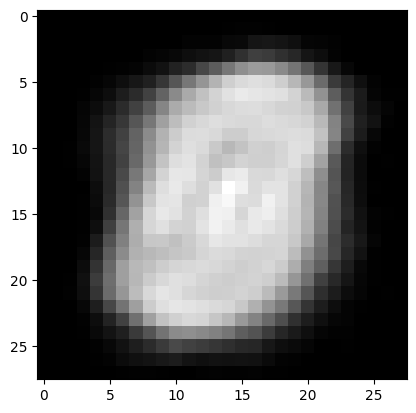

In [5]:
plt.imshow(wi, cmap='gray')

## Define Model

In [6]:
class DAC(models.Model):
    def __init__(self):
        super(DAC, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(784,)),
            layers.Dense(512),
            layers.Activation('relu'),
            layers.Activation('tanh'),
            layers.Dense(128),
            layers.Activation('relu'),
            layers.Activation('tanh'),
            layers.Dense(32),
            layers.Activation('tanh'),
            layers.Dense(10)
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(32, input_shape=(10,)),
            layers.Activation('tanh'),
            layers.Dense(128),
            layers.Activation('tanh'),
            layers.Dense(512),
            layers.Activation('tanh'),
            layers.Dense(784),
            layers.Activation('sigmoid'), 
        ])

    def call(self, x):
        latent_space = self.encoder(x)
        reconstructed = self.decoder(latent_space)
        return latent_space, reconstructed

## Define loos function and train the model

In [7]:
model = DAC()
optimizer = optimizers.Adam(learning_rate=1e-3)

def cmse_loss(outputs, inputs, weights):
    expanded_weights = tf.broadcast_to(tf.reshape(weights, [-1, 784]), [tf.shape(outputs)[0], 784])
    return tf.reduce_mean(tf.multiply(tf.square(tf.cast(outputs, tf.float32) - tf.cast(inputs, tf.float32)), tf.cast(expanded_weights, tf.float32)))

def train_step(model, inputs, weights, optimizer):
    with tf.GradientTape() as tape:
        _, outputs = model(inputs)
        loss = cmse_loss(outputs, inputs, weights) + tf.reduce_mean(tf.square(tf.cast(outputs, tf.float32) - tf.cast(inputs, tf.float32))) * 0.00001
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, _) in enumerate(train_dataset):
        inputs = tf.reshape(inputs, [-1, 784])
        loss = train_step(model, inputs, wi, optimizer)
        running_loss += loss

        if i % 100 == 99:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_dataset)}], Loss: {running_loss / 100:.4f}')
            running_loss = 0.0

J:\Users\parsa\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch [1/10], Step [100/938], Loss: 0.0103
Epoch [1/10], Step [200/938], Loss: 0.0074
Epoch [1/10], Step [300/938], Loss: 0.0063
Epoch [1/10], Step [400/938], Loss: 0.0056
Epoch [1/10], Step [500/938], Loss: 0.0051
Epoch [1/10], Step [600/938], Loss: 0.0047
Epoch [1/10], Step [700/938], Loss: 0.0044
Epoch [1/10], Step [800/938], Loss: 0.0043
Epoch [1/10], Step [900/938], Loss: 0.0040
Epoch [2/10], Step [100/938], Loss: 0.0037
Epoch [2/10], Step [200/938], Loss: 0.0037
Epoch [2/10], Step [300/938], Loss: 0.0037
Epoch [2/10], Step [400/938], Loss: 0.0035
Epoch [2/10], Step [500/938], Loss: 0.0035
Epoch [2/10], Step [600/938], Loss: 0.0034
Epoch [2/10], Step [700/938], Loss: 0.0033
Epoch [2/10], Step [800/938], Loss: 0.0034
Epoch [2/10], Step [900/938], Loss: 0.0032
Epoch [3/10], Step [100/938], Loss: 0.0031
Epoch [3/10], Step [200/938], Loss: 0.0031
Epoch [3/10], Step [300/938], Loss: 0.0032
Epoch [3/10], Step [400/938], Loss: 0.0030
Epoch [3/10], Step [500/938], Loss: 0.0030
Epoch [3/10

## checking the prediction of model

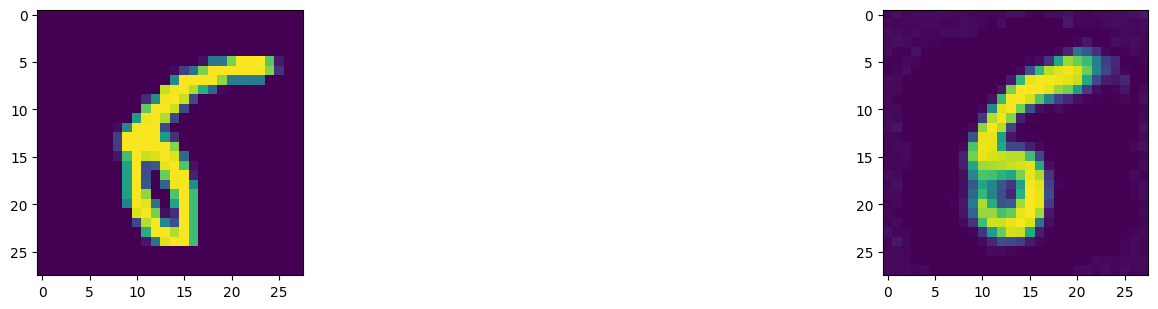

In [32]:
plt.figure(figsize=(20, 20))
plt.subplot(5, 2, 1)
plt.imshow(x_train[8898])
plt.subplot(5, 2, 2)
plt.imshow(y_train_pred.reshape(-1, 28, 28)[8898])
plt.show()

## Calculating the dependence of the clustering basis on the labels of the photos

### Default photos

In [8]:
kmeans = KMeans(n_clusters=10)
clusters_defualt = kmeans.fit_predict(x_train.reshape(-1, 784))

In [9]:
cluster_percent_defualt = list()
for i in range(10):
    cluster_percent_defualt.append(sorted(list(zip(*np.unique(y_train[clusters_defualt==i], return_counts=True))), key=lambda x:x[1], reverse=True)[0][1] / len(y_train[clusters_defualt==i]))
print('The average dependence of the clustering basis on the labels of the images using the default images is {}%.'.format(np.mean(cluster_percent_defualt)))

The average dependence of the clustering basis on the labels of the images using the default images is 0.562930760708569%.


### Latent space

In [10]:
latent_space, y_train_pred = model.predict(x_train.reshape(-1, 784))

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step


In [11]:
kmeans = KMeans(n_clusters=10)
clusters_DAC = kmeans.fit_predict(latent_space)

In [12]:
cluster_percent_DAC = list()
for i in range(10):
    cluster_percent_DAC.append(sorted(list(zip(*np.unique(y_train[clusters_DAC==i], return_counts=True))), key=lambda x:x[1], reverse=True)[0][1] / len(y_train[clusters_DAC==i]))
print('The average dependence of the clustering basis on the labels of the images using the latent space is {}%.'.format(np.mean(cluster_percent_DAC)))

The average dependence of the clustering basis on the labels of the images using the latent space is 0.6929592149100096%.
